# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
#Import all the required libraries
import glob
from PIL import Image
import pandas as pd
import numpy as np
from functools import reduce
from collections import Counter
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 
import seaborn as sns
from pickle import dump,load
import time

import keras
from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from nltk.corpus import stopwords
from keras.preprocessing import sequence
from keras.models import Sequential
# import tensorflow.compat.v1.keras.backend as K


from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Conv2D

from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [2]:
#Import the dataset and read the image into a seperate variable

images='./Flickr8K/Images'

all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


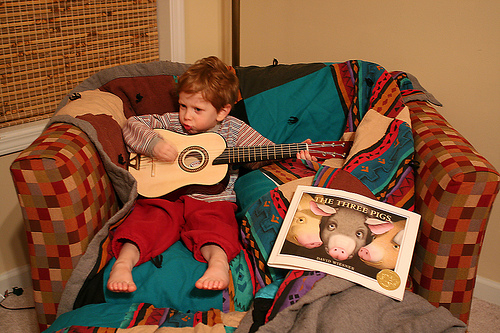

In [3]:
#Visualise both the images & text present in the dataset
Image.open(all_imgs[0])

In [4]:
#Import the dataset and read the text file into a seperate variable

def load_doc(filename):
    #your code here
    text=open(filename).read()
    return text

def get_img_ids_and_captions(text):
    keys=[]
    values=[]
    key_paths=[]
    text=text.splitlines()[1:]
    for line in text:
        com_idx=line.index(",")
        im_id,im_cap=line[:com_idx],line[com_idx+1:]
        keys.append(im_id)
        values.append(im_cap)
        key_paths.append(images+'/'+im_id)
    return keys,values,key_paths

text_file="./Flickr8K/captions.txt"

doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [5]:
# all_img_id= #store all the image id here
# all_img_vector= #store all the image path here
# annotations= #store all the captions here
all_img_id,annotations,all_img_vector= get_img_ids_and_captions(doc)

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df.head()

,ID,Path,Captions
0,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,./Flickr8K/Images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 3 columns):
ID          40455 non-null object
Path        40455 non-null object
Captions    40455 non-null object
dtypes: object(3)
memory usage: 948.3+ KB


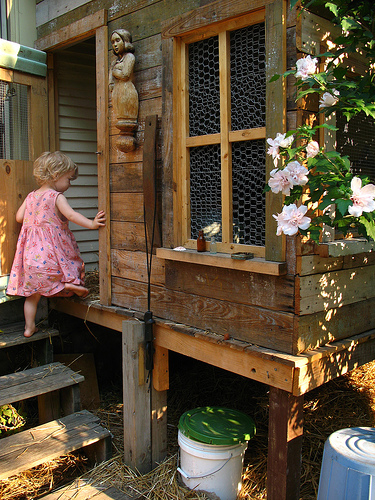

In [7]:
Image.open(all_img_vector[0])

In [8]:
#Create the vocabulary & the counter for the captions
def voc_fetcher(frame,column):
    out=[]
    for i in frame[column]:
        out+=i.split(" ")
    return out

vocabulary=voc_fetcher(df,"Captions")
val_count=Counter(vocabulary)
val_count

Counter({'A': 21481,
         'child': 1477,
         'in': 18961,
         'a': 40271,
         'pink': 734,
         'dress': 347,
         'is': 9345,
         'climbing': 502,
         'up': 1260,
         'set': 108,
         'of': 6712,
         'stairs': 109,
         'an': 1944,
         'entry': 1,
         'way': 50,
         '.': 34212,
         'girl': 3217,
         'going': 149,
         'into': 1074,
         'wooden': 284,
         'building': 509,
         'little': 1625,
         'playhouse': 6,
         'the': 15328,
         'to': 3173,
         'her': 1178,
         'cabin': 4,
         'black': 3696,
         'dog': 7982,
         'and': 8850,
         'spotted': 37,
         'are': 3503,
         'fighting': 132,
         'tri-colored': 14,
         'playing': 2008,
         'with': 7760,
         'each': 430,
         'other': 771,
         'on': 10729,
         'road': 388,
         'white': 3875,
         'brown': 2475,
         'spots': 29,
         'staring'

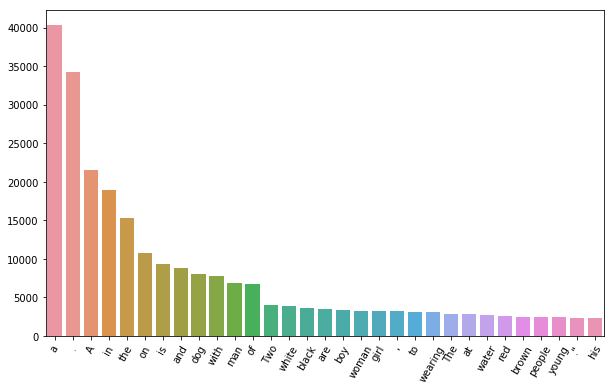

In [9]:
#Visualise the top 30 occuring words in the captions
def get_top_words_based_on_cnt(words_dict,n_words):
    n_words+=1
    keys=list(words_dict.keys())
    values=list(words_dict.values())
    sorted_values=sorted(values,reverse=True)[:n_words]
    sorted_keys=[]
    for i in sorted_values:
        if sorted_values.count(i)==1:
            sorted_keys.append(keys[values.index(i)])
        elif sorted_values.count(i)==2:
            f_idx=values.index(i)
            s_idx=values[f_idx+1:].index(i)
            s_idx+=f_idx+1
            a,b=keys[f_idx],keys[s_idx]
            if a not in sorted_keys and b not in sorted_keys:
                sorted_keys.append(a)
                sorted_keys.append(b)
    plt.figure(figsize=(10,6))
    sns.barplot(x=sorted_keys,y=sorted_values)
    plt.xticks(rotation=60)
    plt.show()
    #write your code here
get_top_words_based_on_cnt(val_count,30)

In [10]:
#Create a list which contains all the captions
annotations= df.Captions.apply(lambda z:"<start>"+" "+z+" "+"<end>") #write your code here

#add the <start> & <end> token to all those captions as well

#Create a list which contains all the path to the images
all_img_path= df.Path.to_list() #write your code here

print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_path)))

Total captions present in the dataset: 40455
Total images present in the dataset: 40455


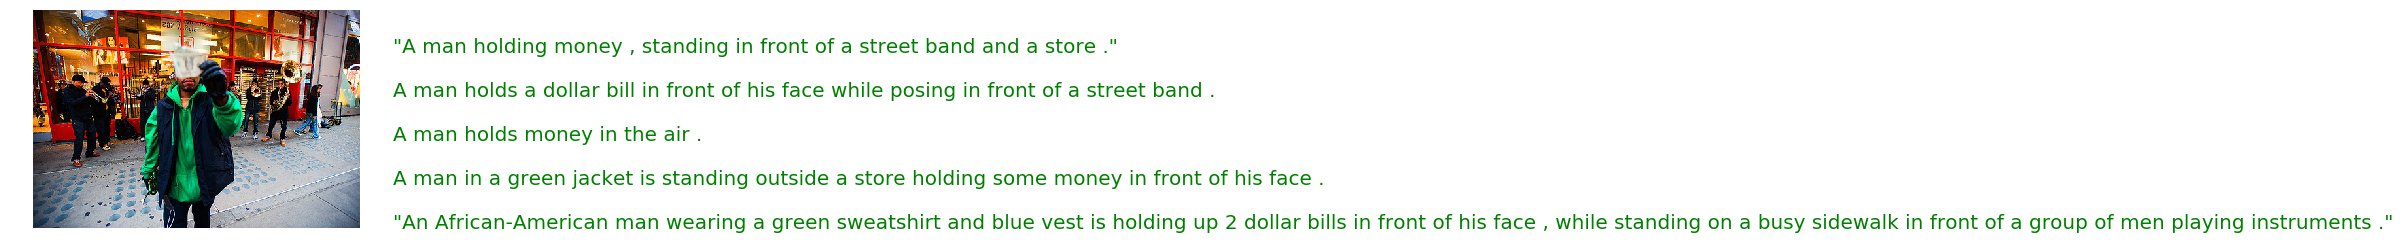

In [11]:
def caption_and_image_plotter(image_id,frame):
    #get captions
    caps=("\n"*2).join(frame[frame['ID']==image_id].Captions.to_list())
    fig, ax = plt.subplots()
    ax.set_axis_off()
    idx=df.ID.to_list().index(image_id)
    im=Image.open(df.Path.iloc[idx])
    w,h=im.size[0],im.size[-1]
    ax.imshow(im)
    ax.text(w+50,h,caps,fontsize=20,color='green')
caption_and_image_plotter(df.ID.iloc[8049],df)

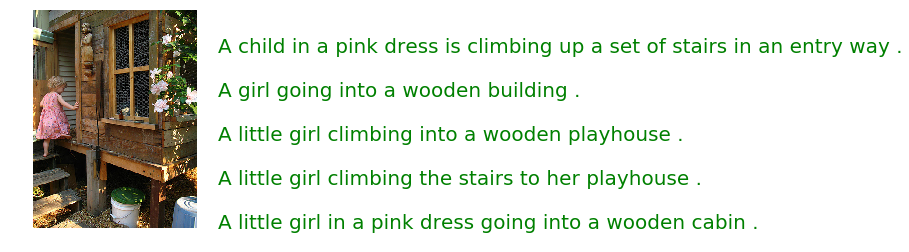

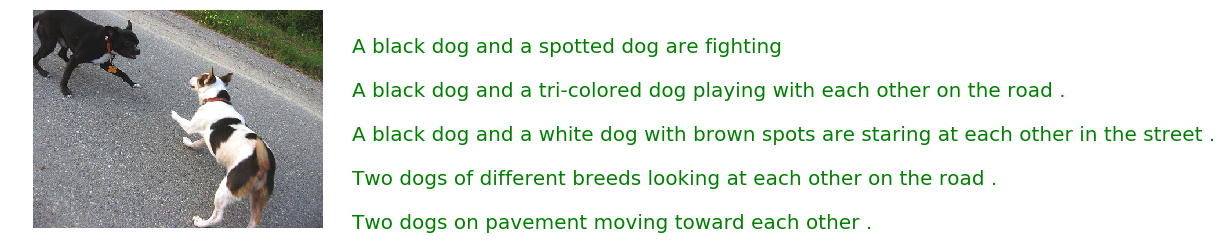

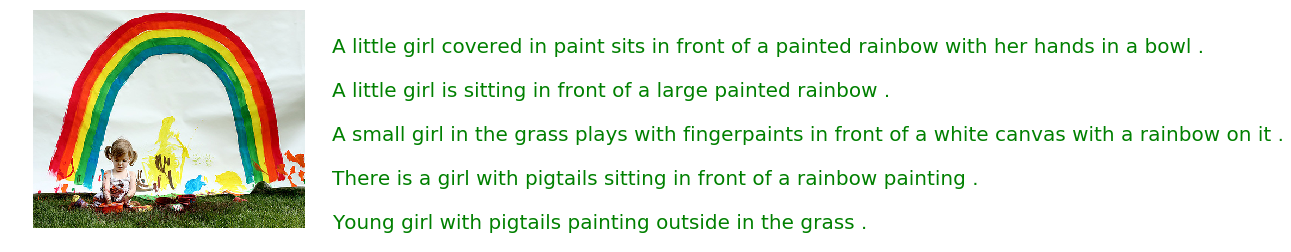

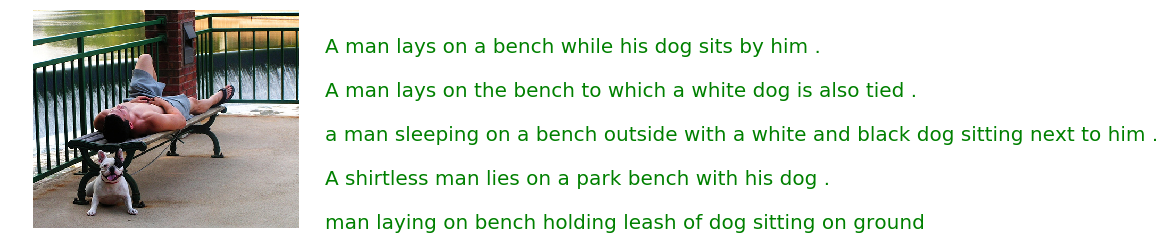

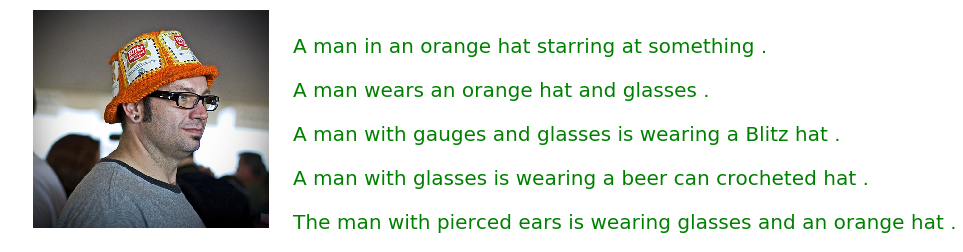

In [12]:
def run_caption_and_image_plotter_for_a_range(start,end,frame):
    for i in range(start,end):
        caption_and_image_plotter(frame.ID.drop_duplicates().iloc[i],frame)
run_caption_and_image_plotter_for_a_range(0,5,df)

## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [13]:
# create the tokenizer

top_word_cnt = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_word_cnt,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(annotations)
train_seqs = tokenizer.texts_to_sequences(annotations)

In [14]:
train_seqs[:5]

[[3, 2, 44, 5, 2, 91, 173, 8, 120, 52, 2, 394, 13, 395, 5, 29, 1, 671, 4],
 [3, 2, 20, 317, 65, 2, 197, 118, 4],
 [3, 2, 41, 20, 120, 65, 2, 197, 2438, 4],
 [3, 2, 41, 20, 120, 6, 395, 21, 61, 2438, 4],
 [3, 2, 41, 20, 5, 2, 91, 173, 317, 65, 2, 197, 2982, 4]]

In [15]:
# Create word-to-index and index-to-word mappings.
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
train_seqs = tokenizer.texts_to_sequences(annotations)

In [16]:
tokenizer.word_counts

OrderedDict([('<start>', 40455),
             ('a', 62992),
             ('child', 1545),
             ('in', 18986),
             ('pink', 739),
             ('dress', 348),
             ('is', 9345),
             ('climbing', 507),
             ('up', 1302),
             ('set', 109),
             ('of', 6723),
             ('stairs', 109),
             ('an', 2432),
             ('entry', 1),
             ('way', 53),
             ('<end>', 40455),
             ('girl', 3328),
             ('going', 149),
             ('into', 1074),
             ('wooden', 284),
             ('building', 510),
             ('little', 1768),
             ('playhouse', 6),
             ('the', 18419),
             ('to', 3176),
             ('her', 1178),
             ('cabin', 4),
             ('black', 3848),
             ('dog', 8138),
             ('and', 8862),
             ('spotted', 38),
             ('are', 3504),
             ('fighting', 133),
             ('tri', 14),
             ('color

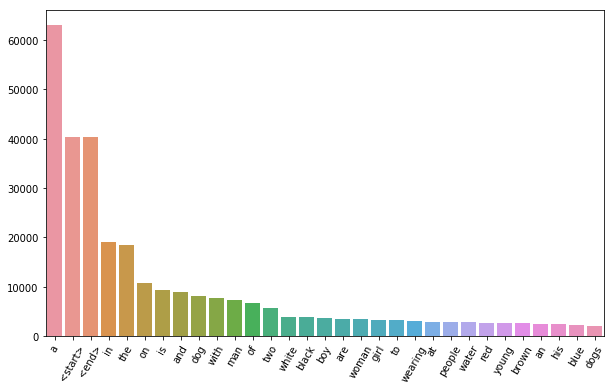

In [17]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing

get_top_words_based_on_cnt(tokenizer.word_counts,30)

In [18]:
def min_max_for_nested_array(nested_array):
    array=[len(e) for e in nested_array]
    return min(array),max(array)
min_l,max_l=min_max_for_nested_array(train_seqs)

In [19]:
# Pad each vector to the max_length of the captions ^ store it to a vairable
cap_vector=tf.keras.preprocessing.sequence.pad_sequences(train_seqs,padding='post',maxlen=max_l)

print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 39)


## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [20]:
#write your code here
def load_the_image(file_path):
    my_img = tf.io.read_file(file_path)
    my_img = tf.image.decode_jpeg(my_img, channels=3)
    my_img = tf.image.resize(my_img, (299, 299))
    my_img = tf.keras.applications.inception_v3.preprocess_input(my_img)
    return my_img,file_path

W0905 17:35:10.834927 140277907498816 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


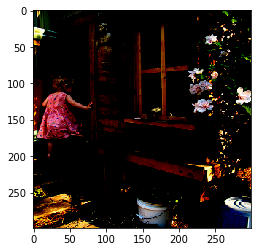

In [21]:
plt.imshow(load_the_image(all_img_path[0])[0])

In [22]:
encode_train_set = sorted(set(all_img_vector))

feature_dict = {}

image_data_set = tf.data.Dataset.from_tensor_slices(encode_train_set)
image_data_set = image_data_set.map(load_the_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

In [23]:
image_data_set

<BatchDataset shapes: ((None, 299, 299, 3), (None,)), types: (tf.float32, tf.string)>

## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


In [24]:
#write your code here
image_train, image_test, caption_train, caption_test = train_test_split(all_img_vector,
                                                                        cap_vector,
                                                                        test_size=0.2,
                                                                        random_state=42)

In [25]:
print("Training data for images: " + str(len(image_train)))
print("Testing data for images: " + str(len(image_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


In [26]:
# sample_img_batch, sample_cap_batch = next(iter(image_data_set))
# print(sample_img_batch.shape) #(batch_size, 299, 299, 3)
# print(sample_cap_batch.shape) #(batch_size, max_len)

In [27]:
def map_function(image_name,capt):
    image_tensor = feature_dict[image_name.decode('utf-8')]
    return image_tensor,capt

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [28]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

new_input = image_model.input  #write code here to get the input of the image_model
hidden_layer = image_model.layers[-1].output  #write code here to get the output of the image_model

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)  #build the final model using both input & output layer

In [29]:
# write your code to extract features from each image in the dataset

image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [30]:
for image,path in tqdm(image_data_set):
    batch_features = image_features_extract_model(image)
    batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))
    for batch_f, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        feature_dict[path_of_feature] =  batch_f.numpy()

253it [00:50,  1.84it/s]


In [31]:
batch_f.shape

TensorShape([64, 2048])

In [32]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
def generate_dataset(images_data, captions_data):
    
    dataset = tf.data.Dataset.from_tensor_slices((images_data, captions_data))
    dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_function, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)


    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [33]:
train_dataset=generate_dataset(image_train,caption_train)
test_dataset=generate_dataset(image_test,caption_test)

In [34]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,40)

(32, 64, 2048)
(32, 39)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [35]:
embedding_dim = 256 
units = 512
vocab_size = 5001 #top 5,000 words +1
train_num_steps = len(image_train) // BATCH_SIZE
test_num_steps = len(image_test) // BATCH_SIZE

### Encoder

In [36]:
class Encoder(tf.keras.Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)
        self.dropout = tf.keras.layers.Dropout(0.5)
        
    def call(self, features):
        features = self.dense(features)  # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = tf.nn.relu(features)
        return features

In [37]:
encoder=Encoder(embedding_dim)

### Attention model

In [38]:
class Attention_model(tf.keras.Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units) #build your Dense layer
        self.W2 = tf.keras.layers.Dense(units) #build your Dense layer
        self.V = tf.keras.layers.Dense(1) #build your final Dense layer with unit 1
        self.units=units

    def call(self, features, hidden):
        #features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1) # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        score = keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis)) # build your score funciton to shape: (batch_size, 8*8, units)
        attention_weights = keras.activations.softmax(self.V(score), axis=1) # extract your attention weights with shape: (batch_size, 8*8, 1)
        context_vector = attention_weights * features #shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = tf.reduce_sum(context_vector, axis=1) # reduce the shape to (batch_size, embedding_dim)
        

        return context_vector, attention_weights

In [39]:
class RNN_Decoder(Model):
    def __init__(self, embedding_dim, units, vocab_size):

        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.gru = layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
        
        self.fc1 = layers.Dense(self.units)
        self.fc2 = layers.Dense(vocab_size)

        self.attention = Attention_model(self.units)

    def call(self, x, features, hidden):
    # defining attention as a separate model
        context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
        output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
        x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

### Decoder

In [40]:
class Decoder(tf.keras.Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim, mask_zero =  False) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer
        self.dropout = tf.keras.layers.Dropout(0.5)
        

    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.dropout(self.embed(x)) # embed your input to shape: (batch_size, 1, embedding_dim)
        mask = self.embed.compute_mask(x)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed,mask=mask) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)
        
        return output,state, attention_weights
    
    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [41]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [42]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [43]:
optimizer = tf.keras.optimizers.Adam() #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none') #define your loss object

In [44]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [45]:
checkpoint_path = "./Flickr8K"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [46]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [47]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
        features = encoder(img_tensor)
        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)
        avg_loss = (loss/int(target.shape[1]))
        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss, avg_loss

In [48]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            dec_input = tf.expand_dims(target[:, i], 1)

        avg_loss = (loss / int(target.shape[1]))

        trainable_variables = encoder.trainable_variables + decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))

        return loss, avg_loss

In [49]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
    avg_test_loss=total_loss/test_num_steps
    return avg_test_loss

In [50]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 1.185, & test loss is 1.012
Time taken for 1 epoch 247.5902407169342 sec

Test loss has been reduced from 100.000 to 1.012


 13%|█▎        | 2/15 [06:20<46:13, 213.36s/it]

For epoch: 2, the train loss is 0.938, & test loss is 0.900
Time taken for 1 epoch 132.74651455879211 sec

Test loss has been reduced from 1.012 to 0.900


 20%|██        | 3/15 [08:33<37:49, 189.13s/it]

For epoch: 3, the train loss is 0.855, & test loss is 0.829
Time taken for 1 epoch 132.4918818473816 sec

Test loss has been reduced from 0.900 to 0.829


 27%|██▋       | 4/15 [10:46<31:35, 172.34s/it]

For epoch: 4, the train loss is 0.794, & test loss is 0.775
Time taken for 1 epoch 133.04209446907043 sec

Test loss has been reduced from 0.829 to 0.775


 33%|███▎      | 5/15 [12:59<26:46, 160.61s/it]

For epoch: 5, the train loss is 0.743, & test loss is 0.728
Time taken for 1 epoch 133.13345408439636 sec

Test loss has been reduced from 0.775 to 0.728


 40%|████      | 6/15 [15:13<22:52, 152.50s/it]

For epoch: 6, the train loss is 0.699, & test loss is 0.687
Time taken for 1 epoch 133.4719181060791 sec

Test loss has been reduced from 0.728 to 0.687


 47%|████▋     | 7/15 [17:26<19:34, 146.80s/it]

For epoch: 7, the train loss is 0.659, & test loss is 0.648
Time taken for 1 epoch 133.35883927345276 sec

Test loss has been reduced from 0.687 to 0.648


 53%|█████▎    | 8/15 [19:40<16:39, 142.81s/it]

For epoch: 8, the train loss is 0.622, & test loss is 0.613
Time taken for 1 epoch 133.39413475990295 sec

Test loss has been reduced from 0.648 to 0.613


 60%|██████    | 9/15 [21:53<13:59, 139.97s/it]

For epoch: 9, the train loss is 0.589, & test loss is 0.580
Time taken for 1 epoch 133.2296278476715 sec

Test loss has been reduced from 0.613 to 0.580


 67%|██████▋   | 10/15 [24:07<11:30, 138.06s/it]

For epoch: 10, the train loss is 0.558, & test loss is 0.550
Time taken for 1 epoch 133.494140625 sec

Test loss has been reduced from 0.580 to 0.550


 73%|███████▎  | 11/15 [26:20<09:06, 136.58s/it]

For epoch: 11, the train loss is 0.530, & test loss is 0.523
Time taken for 1 epoch 132.9999499320984 sec

Test loss has been reduced from 0.550 to 0.523


 80%|████████  | 12/15 [28:33<06:46, 135.57s/it]

For epoch: 12, the train loss is 0.504, & test loss is 0.500
Time taken for 1 epoch 133.07479572296143 sec

Test loss has been reduced from 0.523 to 0.500


 87%|████████▋ | 13/15 [30:46<04:29, 134.74s/it]

For epoch: 13, the train loss is 0.482, & test loss is 0.476
Time taken for 1 epoch 132.68866324424744 sec

Test loss has been reduced from 0.500 to 0.476


 93%|█████████▎| 14/15 [32:58<02:14, 134.05s/it]

For epoch: 14, the train loss is 0.461, & test loss is 0.455
Time taken for 1 epoch 132.33254623413086 sec

Test loss has been reduced from 0.476 to 0.455


100%|██████████| 15/15 [35:11<00:00, 133.56s/it]

For epoch: 15, the train loss is 0.442, & test loss is 0.440
Time taken for 1 epoch 132.2857587337494 sec

Test loss has been reduced from 0.455 to 0.440


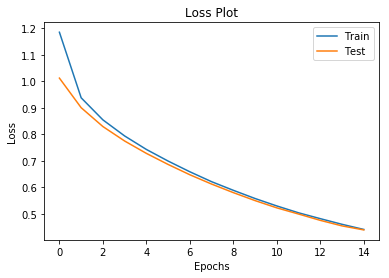

In [51]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.legend(["Train", "Test"], loc ="best")
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [52]:
# image_features_extract_model(temp_input) def evaluate(image):
def evaluate(image):
    max_length=max_l
    
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0) #process the input image to desired format before extracting features
    img_tensor_val = image_features_extract_model(temp_input) # Extract features using our feature extraction model
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val) # extract the features by passing the input to encoder

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden) # get the output from decoder

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy() #extract the predicted id(embedded value) which carries the max value
        result.append(tokenizer.index_word[predicted_id]) #map the id to the word from tokenizer and append the value to the result list

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [53]:
def beam_evaluate(image, beam_index = 3): #your value for beam index):
    max_length=max_l
    start = [tokenizer.word_index['<start>']]
    result = [[start, 0.0]]

    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_the_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    while len(result[0][0]) < max_length:
        i=0
        temp = []
        for s in result:
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
            attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
            i=i+1
            word_preds = np.argsort(predictions[0])[-beam_index:]
          
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
            
                prob += np.log(predictions[0][w])
                    
                temp.append([next_cap, prob])
        result = temp
        result = sorted(result, reverse=False, key=lambda l: l[1])
        result = result[-beam_index:]
        
        
        predicted_id = result[-1]
        pred_list = predicted_id[0]
        
        prd_id = pred_list[-1] 
        if(prd_id!=3):
            dec_input = tf.expand_dims([prd_id], 0)  
        else:
            break
    
    
    result2 = result[-1][0]
    
    intermediate_caption = [tokenizer.index_word[i] for i in result2]
    final_caption = []
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
            
        else:
            break

    attention_plot = attention_plot[:len(result), :]
    final_caption = ' '.join(final_caption[1:])
                  
    return final_caption



In [54]:
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot(len_cap//2, len_cap//2, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [55]:
from nltk.translate.bleu_score import sentence_bleu

In [56]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [57]:
features_shape = batch_f.shape[1]
attention_features_shape = batch_f.shape[0]

5073
BELU score: 1.171778691554733e-229
Real Caption: a person performing gets from his apparatus
Prediction Caption: a man falling off his surfboard


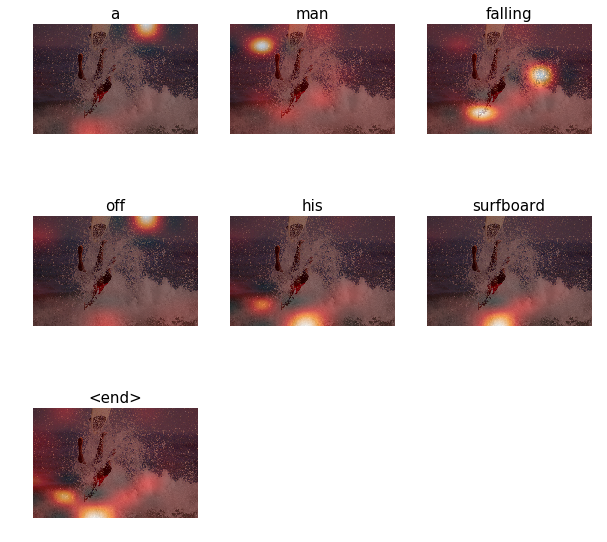

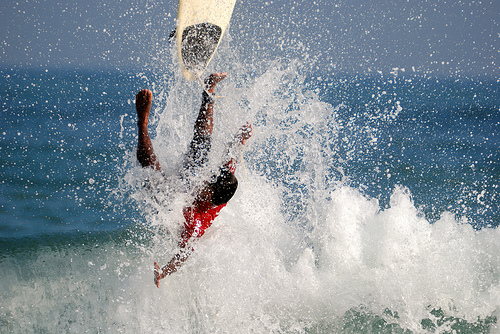

In [58]:
rid = np.random.randint(0, len(image_test))
print(rid)
test_image = image_test[rid]
#test_image = './images/413231421_43833a11f5.jpg'
#real_caption = '<start> black dog is digging in the snow <end>'

real_caption = ' '.join([tokenizer.index_word[i] for i in caption_test[rid] if i not in [0]])
result, attention_plot,pred_test = evaluate(test_image)


real_caption=filt_text(real_caption)      


pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights= (0.25, 0.25, 0.25, 0.25))#set your weights)
print(f"BELU score: {score*100}")

print('Real Caption:', real_caption)
print('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [59]:
captions= evaluate(test_image)
print(pred_caption)
print(captions)

a man falling off his surfboard
(['a', 'man', 'falling', 'off', 'his', 'surfboard', '<end>'], array([[4.55897680e-04, 9.10720322e-03, 7.58078357e-04, ...,
        2.64209020e-03, 1.67721871e-03, 1.42332156e-05],
       [6.55262556e-06, 2.42908674e-04, 4.38171513e-02, ...,
        3.15702368e-06, 1.07079313e-06, 4.00393176e-08],
       [1.09827752e-07, 2.57643260e-04, 1.21254064e-02, ...,
        4.53341357e-07, 9.11595279e-08, 4.47900383e-09],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]), <tf.Tensor: shape=(1, 5001), dtype=float32, numpy=
array([[-15.729633 ,   8.202713 ,   7.36672  , ..., -16.085632 ,
         -7.8558464, -16.149317 ]], dtype=float32)>)


### Converting Text to Speech

In [60]:
# ! pip install gTTS

In [61]:
from gtts import gTTS
import IPython.display as ipd

# Language in which you want to convert
language = 'en'
  
# Passing the text and language to the engine, 
myobj = gTTS(text=pred_caption, lang=language, slow=False)
  
# Saving the converted audio in a mp3 file named
myobj.save("Predicted_text.mp3")
  
# Playing the converted file
ipd.Audio("./Predicted_text.mp3") # load a local WAV file


In [62]:
captions= beam_evaluate(test_image)
print(pred_caption)
print(captions)

a man falling off his surfboard
a child is off his apparatus


In [63]:
myobj = gTTS(text=pred_caption, lang=language, slow=False)
  
myobj.save("beam_Predicted_text.mp3")

ipd.Audio("./beam_Predicted_text.mp3") 